# PSP analysis 

In this note, we analyze a dataset for Progressive Supranuclear Palsy (PSP), which includes RNA-Seq data from 25 PSP patients and 16 controls with total of 104 transcriptom.

- Our analysis begins with a 3-fold cross-validation using XGBoost, where we compute and plot the average AUC, specificity, sensitivity, and accuracy scores with standard deviation error bars.

- We then compare XGBoost with other models such as Random Forest, CatBoost, and SVM. Our comparison reveals clear overfitting issues in Random Forest, CatBoost, and SVM.

- To address this, we perform a 5-fold cross-validation and explore hyperparameters for these models, but the overfitting issue persists.

- To mitigate this, we conduct feature importance selection to identify the top 30 genes based on the models previously mentioned, and focus on the common genes among these top selections, which total 5 genes.

- We then apply Logistic Regression and

- CatBoost based on these common genes, observing that while these models show high sensitivity, they exhibit lower specificity.

- Finally, we investigate Lasso Regression and Ridge Regression as additional methods. We find that Lasso Regression effectively mitigates overfitting, whereas Ridge Regression continues to suffer from overfitting issues.

In [1]:
import shap
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from collections import Counter
from pathlib import Path

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import os

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
#os.getcwd()

'/home/ebri/Documenti/psp'

In [2]:
path1=Path("/Users/zainabnazari/psp/new_data_12_6_2025")


In [3]:
w_psp_data=pd.read_csv(path1/"mydata_TMM_Norm_Log2_CPM_M1_filtered_STAR_align_HtSeq_top_2212_ParCor_Spearman_p_1pc.txt",delimiter='\t')


In [4]:
w_psp_data.set_index('ID', inplace=True)

In [5]:
w_psp_data


,CTR001,CTR002,CTR003,CTR004,CTR005,CTR006,CTR007,CTR009,CTR010,CTR012,...,PSP016,PSP017,PSP018,PSP019,PSP020,PSP021,PSP022,PSP023,PSP024,PSP025
ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000100422,6.506574,6.837920,6.772722,6.747701,6.618395,6.921674,6.755341,6.747092,6.777050,6.710424,...,6.913361,6.919585,6.537452,6.594185,6.794908,6.809616,6.993349,6.760549,6.982361,6.642065
ENSG00000164941,6.119330,6.043177,6.002901,6.009847,5.677839,5.911585,6.057230,6.030343,6.071518,6.298489,...,6.182782,5.874453,5.828374,5.899559,5.999941,6.037048,5.970769,5.844641,5.940841,5.919284
ENSG00000250222,-0.228555,0.080095,-1.407259,-0.647067,-1.082175,-0.361441,-0.021479,-1.153149,-1.100401,-0.913524,...,-2.351194,-0.423275,-0.540340,-0.899799,-0.346093,-1.077687,-0.249103,-0.712527,-0.805295,-0.747389
ENSG00000288772,0.499942,0.528018,-0.026939,0.419582,0.295217,0.049184,0.187412,-0.142911,-0.255263,0.244653,...,-0.317880,0.481836,-0.729909,0.894547,0.065057,-0.134603,-0.398822,0.375546,0.160581,0.176073
ENSG00000252050,-0.762079,0.131687,-1.127767,-1.301907,-0.868301,-0.442867,0.335159,-0.225973,-0.536890,0.055878,...,-0.736582,-0.423275,-0.086798,-0.232808,-0.514078,-0.229998,0.124654,-0.854666,-0.496920,-0.269930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000221025,-0.070314,-1.617697,0.628237,0.091830,-0.441282,0.981428,0.562096,1.085299,0.660590,0.934619,...,-0.736582,-0.014826,0.535667,0.503862,0.723713,1.379158,0.507937,-0.354722,-0.078151,0.482193
ENSG00000240401,1.567660,1.648616,0.932333,0.540061,0.250152,0.780836,0.531781,0.821393,0.591142,1.686714,...,1.148520,0.784013,0.617561,0.684382,1.117865,1.094162,1.170846,1.672109,1.002999,0.411535
ENSG00000157404,0.659065,1.979489,1.957161,1.472122,0.842484,1.993509,1.261467,1.803209,1.812397,1.750411,...,1.900152,1.387776,1.868274,1.831922,1.720009,1.442404,0.810471,0.763945,0.733987,1.262041


In [6]:
diagnosis_row = [0 if col.startswith('CTR') else 1 for col in w_psp_data.columns]
w_psp_data.loc['Diagnosis'] = diagnosis_row

In [7]:
full_data = w_psp_data.T

In [16]:
full_data

ID,ENSG00000100422,ENSG00000164941,ENSG00000250222,ENSG00000288772,ENSG00000252050,ENSG00000288833,ENSG00000122692,ENSG00000276216,ENSG00000115841,ENSG00000258302,...,ENSG00000200563,ENSG00000267855,ENSG00000286787,ENSG00000112149,ENSG00000221025,ENSG00000240401,ENSG00000157404,ENSG00000240808,ENSG00000212445,Diagnosis
CTR001,6.506574,6.119330,-0.228555,0.499942,-0.762079,-0.845117,6.141067,-0.070314,2.451738,-0.121157,...,-0.538289,-0.173857,1.379317,2.576632,-0.070314,1.567660,0.659065,-0.845117,-0.609097,0.0
CTR002,6.837920,6.043177,0.080095,0.528018,0.131687,-1.059498,6.160372,0.131687,2.850967,0.365137,...,-0.275485,-0.086768,1.194489,2.126602,-1.617697,1.648616,1.979489,-0.209798,0.928866,0.0
CTR003,6.772722,6.002901,-1.407259,-0.026939,-1.127767,-1.260755,6.214196,0.382818,2.618162,0.290766,...,-1.006009,-0.285763,0.805017,3.429478,0.628237,0.932333,1.957161,-0.601399,0.086915,0.0
CTR004,6.747701,6.009847,-0.647067,0.419582,-1.301907,-1.447098,6.104073,0.241492,2.824680,-0.198320,...,-1.998473,0.288118,1.934607,3.881109,0.091830,0.540061,1.472122,-0.937647,-0.647067,0.0
CTR005,6.618395,5.677839,-1.082175,0.295217,-0.868301,-0.441282,6.098313,0.338918,2.807547,0.155564,...,-0.971278,0.203633,1.510855,2.768130,-0.441282,0.250152,0.842484,-0.772187,0.105838,0.0
CTR006,6.921674,5.911585,-0.361441,0.049184,-0.442867,-0.442867,6.006663,-0.529165,2.681860,-0.075142,...,-0.718984,-0.620955,1.564073,2.407685,0.981428,0.780836,1.993509,-0.620955,-0.361441,0.0
CTR007,6.755341,6.057230,-0.021479,0.187412,0.335159,-0.496290,6.071130,-0.435131,2.807829,-0.265821,...,-1.690426,0.022789,1.146132,3.236883,0.562096,0.531781,1.261467,-0.376459,0.299616,0.0
CTR009,6.747092,6.030343,-1.153149,-0.142911,-0.225973,-0.859911,6.177992,0.148449,2.934526,0.010112,...,-0.732983,0.274674,1.248033,2.382058,1.085299,0.821393,1.803209,0.274674,0.010112,0.0
CTR010,6.777050,6.071518,-1.100401,-0.255263,-0.536890,-1.100401,6.174526,-0.019736,2.882703,-0.536890,...,-1.100401,0.182682,1.430323,3.159530,0.660590,0.591142,1.812397,-0.701422,-0.536890,0.0
CTR012,6.710424,6.298489,-0.913524,0.244653,0.055878,-1.374931,6.080375,0.411560,2.648663,-0.161369,...,-1.374931,-0.728468,0.934619,2.580200,0.934619,1.686714,1.750411,0.330519,-0.728468,0.0


In [38]:
# Assuming full_data is your DataFrame
# The index column is the patient names, diagnosis is the target, and gene columns are the features

# Separate features (X) and target (y)
X = full_data.drop(columns=['Diagnosis'])  # Gene expression data (features)
y = full_data['Diagnosis']  # Diagnosis (target)

# Split the dataset into training and testing sets (80% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We use probabilities for the positive class (1)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.2f}")


AUC Score: 0.60


In [ ]:
# TOP Genes

Top 20 Important Genes:
                 Gene  Importance
246   ENSG00000225579    0.173858
1401  ENSG00000251703    0.148214
985   ENSG00000168255    0.140914
781   ENSG00000257390    0.112165
422   ENSG00000162461    0.097633
113   ENSG00000130305    0.093857
181   ENSG00000122783    0.049569
0     ENSG00000100422    0.045556
1369  ENSG00000099365    0.039282
791   ENSG00000189223    0.035680
25    ENSG00000117308    0.026971
1252  ENSG00000281357    0.016736
16    ENSG00000238121    0.015470
165   ENSG00000288542    0.004095
1110  ENSG00000106976    0.000000
1117  ENSG00000271122    0.000000
1122  ENSG00000228495    0.000000
1121  ENSG00000219085    0.000000
1120  ENSG00000203286    0.000000
1119  ENSG00000182973    0.000000


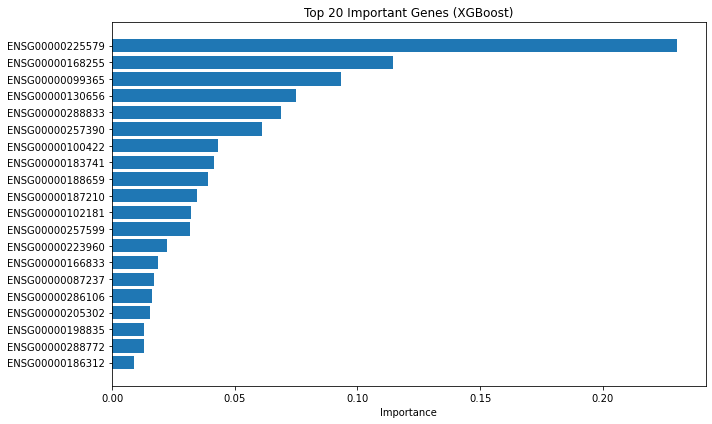

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = pd.DataFrame({
    'Gene': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Get the top 20 most important genes
top_20_genes = feature_importances.head(20)

print("Top 20 Important Genes:")
print(top_20_genes)

# Optional: plot the top 20 for visualization
top_20 = top_50_genes.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_20['Gene'][::-1], top_20['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Important Genes (XGBoost)")
plt.tight_layout()
plt.show()


In [4]:
psp_data=pd.read_csv(path2/"DEGs_102_intesect_edgeR_vs_Limma_vs_DESeq2_Pval_5pc_2fc_with_IDs.txt",delimiter='\t')
print(psp_data.shape)
print(psp_data['Class'].value_counts())
psp_data.head(10)

(41, 104)
PSP    25
CTR    16
Name: Class, dtype: int64


,ENST00000373606,ENST00000395496,ENST00000380265,ENST00000636319,ENST00000374176,ENST00000514815,ENST00000490311,ENST00000484279,ENST00000472481,ENST00000294256,...,ENST00000356891,ENST00000377685,ENST00000429892,ENST00000511980,ENST00000362698,ENST00000391141,ENST00000481445,ENST00000293842,Class,ID
0,1.288816,-1.882510,1.621093,2.572735,1.808860,-1.234000,1.423694,0.256728,1.691537,1.376957,...,1.547033,3.157894,-4.354783,1.184119,0.520252,0.467694,-1.419551,0.570963,CTR,CTR001
1,1.506875,-1.785866,-4.354783,1.715456,2.659513,-0.912864,-1.086667,2.514848,0.762630,-3.489044,...,-3.857925,-2.561170,-2.254110,2.173043,0.939312,0.745441,2.179457,1.162930,CTR,CTR002
2,1.556950,-2.687329,1.657670,0.754520,2.359989,1.269290,-1.361125,1.724210,2.496787,-1.934417,...,-4.354783,1.482014,1.004465,1.064401,0.876564,0.539077,-3.149440,0.153984,CTR,CTR003
3,0.165244,-2.114075,-2.945458,-1.206400,1.946038,1.343601,-1.275391,1.366427,3.191344,2.062438,...,0.028821,0.289874,-0.153984,4.118564,0.359791,0.426475,-2.114075,0.720260,CTR,CTR004
4,0.890442,-1.664276,0.183833,0.968123,4.112507,-1.977253,-1.407240,-1.664276,2.259018,-0.590374,...,1.027390,2.465978,-2.098733,-1.123208,0.018404,0.103489,-0.635628,0.825138,CTR,CTR005
5,0.553468,-1.809297,-2.890486,-2.044907,2.054712,1.539948,1.622840,2.039705,2.216925,-3.828892,...,0.750666,-0.668259,1.440621,1.632875,0.466366,1.452001,1.888769,1.701228,CTR,CTR006
6,0.372680,2.272936,0.153191,-0.556137,1.196267,1.530812,0.882012,2.839698,2.222477,-0.389906,...,-0.269466,-0.080227,-0.591812,1.247635,3.874523,3.387423,0.017716,3.314621,CTR,CTR007
7,-1.359074,1.048513,-1.684319,-0.304944,1.768079,1.171200,-1.265136,1.925777,2.735136,0.674732,...,0.601808,1.664462,-0.214360,1.154299,-1.093832,-0.258941,-3.735010,-1.811360,CTR,CTR009
8,1.656127,-2.098099,-4.354783,2.444103,2.115606,1.155902,-0.486481,2.601654,2.601654,1.621908,...,-4.354783,-0.040478,1.904082,-2.098099,0.865455,0.383804,-0.918463,1.314293,CTR,CTR010
9,0.746734,-1.338271,-4.354783,0.861271,3.816292,1.987569,-0.183175,-4.354783,2.401314,2.049280,...,-0.499294,4.173005,-0.728654,-0.499294,2.142835,1.180940,-3.080719,1.531649,CTR,CTR012


In [18]:
# Separate features (X) and target variable (y)
X1 = full_data.drop(['Diagnosis'], axis=1)

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'COHORT' column
label = label_encoder.fit_transform(full_data['Diagnosis'])

# Set the label for parkinson's disease and healthy control
full_data.loc[:, 'Diagnosis'] = label


y = full_data['Diagnosis']

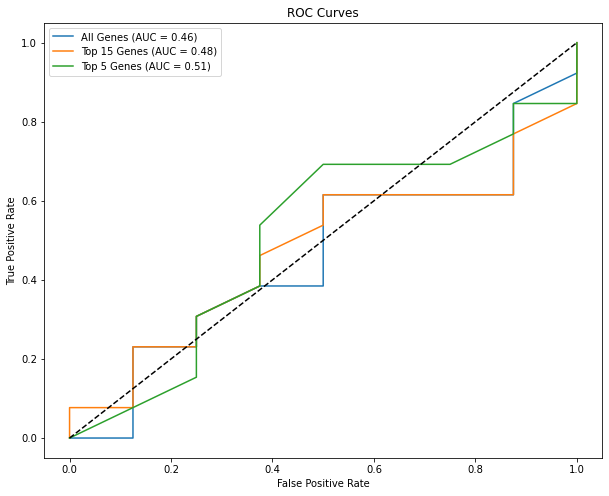

AUC for All Genes: 0.46
AUC for Top 15 Genes: 0.48
AUC for Top 5 Genes: 0.51


In [20]:
# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.5, random_state=42)


# Step 2: Train XGBoost on Training Set , it is not using test set!!
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train, y_train)

# Step 3: Get feature importance and select top genes
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Select top 15 and top 5 genes
top_15_genes = X_train.columns[indices[:15]]
top_5_genes = X_train.columns[indices[:5]]

# Step 4: Evaluate model with top 15 and top 5 genes
xgb_model_top15 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top15.fit(X_train[top_15_genes], y_train)

xgb_model_top5 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top5.fit(X_train[top_5_genes], y_train)


# Step 5: Plot ROC Curve for all genes, top 15, and top 5
def plot_roc_curves(models, X_test, y_test, gene_set_labels):
    plt.figure(figsize=(10, 8))
    for model, genes, label in zip(models, X_test, gene_set_labels):
        y_pred_proba = model.predict_proba(genes)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

# Step 6: ROC Curves for all genes, top 15 and top 5 genes, on test data set
plot_roc_curves(
    models=[xgb_model, xgb_model_top15, xgb_model_top5],
    X_test=[X_test, X_test[top_15_genes], X_test[top_5_genes]],
    y_test=y_test,
    gene_set_labels=['All Genes', 'Top 15 Genes', 'Top 5 Genes']
)


# Step 7: Calculate and print AUC scores
auc_all_genes = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_top15 = roc_auc_score(y_test, xgb_model_top15.predict_proba(X_test[top_15_genes])[:, 1])
auc_top5 = roc_auc_score(y_test, xgb_model_top5.predict_proba(X_test[top_5_genes])[:, 1])

print(f"AUC for All Genes: {auc_all_genes:.2f}")
print(f"AUC for Top 15 Genes: {auc_top15:.2f}")
print(f"AUC for Top 5 Genes: {auc_top5:.2f}")


In [21]:
top_15_genes

Index(['ENSG00000162461', 'ENSG00000251703', 'ENSG00000257390',
       'ENSG00000112305', 'ENSG00000099365', 'ENSG00000276603',
       'ENSG00000130656', 'ENSG00000285230', 'ENSG00000276216',
       'ENSG00000279656', 'ENSG00000104951', 'ENSG00000289293',
       'ENSG00000241597', 'ENSG00000061337', 'ENSG00000198468'],
      dtype='object', name='ID')

In [22]:
top_5_genes

Index(['ENSG00000162461', 'ENSG00000251703', 'ENSG00000257390',
       'ENSG00000112305', 'ENSG00000099365'],
      dtype='object', name='ID')

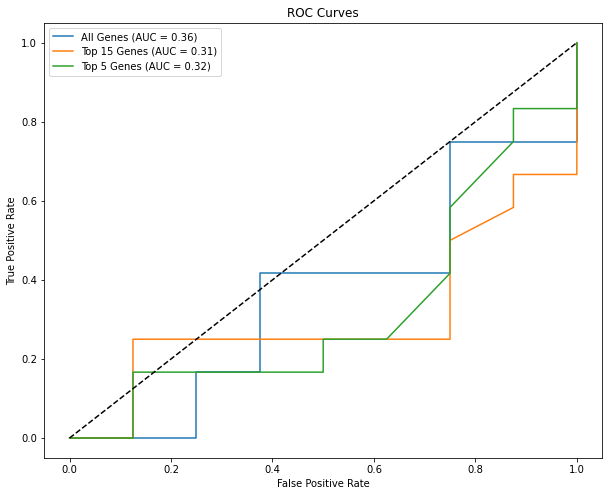

AUC for All Genes: 0.36
AUC for Top 15 Genes: 0.31
AUC for Top 5 Genes: 0.32


In [23]:
# Step 1: Train-Test Split
X_test, X_train, y_test, y_train = train_test_split(X1, y, test_size=0.5, random_state=42)


# Step 2: Train XGBoost on Training Set , it is not using test set!!
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train, y_train)

# Step 3: Get feature importance and select top genes
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Select top 15 and top 5 genes
top_15_genes = X_train.columns[indices[:15]]
top_5_genes = X_train.columns[indices[:5]]

# Step 4: Evaluate model with top 15 and top 5 genes
xgb_model_top15 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top15.fit(X_train[top_15_genes], y_train)

xgb_model_top5 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top5.fit(X_train[top_5_genes], y_train)


# Step 5: Plot ROC Curve for all genes, top 15, and top 5
def plot_roc_curves(models, X_test, y_test, gene_set_labels):
    plt.figure(figsize=(10, 8))
    for model, genes, label in zip(models, X_test, gene_set_labels):
        y_pred_proba = model.predict_proba(genes)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

# Step 6: ROC Curves for all genes, top 15 and top 5 genes, on test data set
plot_roc_curves(
    models=[xgb_model, xgb_model_top15, xgb_model_top5],
    X_test=[X_test, X_test[top_15_genes], X_test[top_5_genes]],
    y_test=y_test,
    gene_set_labels=['All Genes', 'Top 15 Genes', 'Top 5 Genes']
)


# Step 7: Calculate and print AUC scores
auc_all_genes = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_top15 = roc_auc_score(y_test, xgb_model_top15.predict_proba(X_test[top_15_genes])[:, 1])
auc_top5 = roc_auc_score(y_test, xgb_model_top5.predict_proba(X_test[top_5_genes])[:, 1])

print(f"AUC for All Genes: {auc_all_genes:.2f}")
print(f"AUC for Top 15 Genes: {auc_top15:.2f}")
print(f"AUC for Top 5 Genes: {auc_top5:.2f}")


In [24]:
top_15_genes

Index(['ENSG00000267526', 'ENSG00000254676', 'ENSG00000163528',
       'ENSG00000280411', 'ENSG00000279583', 'ENSG00000142528',
       'ENSG00000100422', 'ENSG00000258302', 'ENSG00000223466',
       'ENSG00000289858', 'ENSG00000207750', 'ENSG00000240809',
       'ENSG00000258111', 'ENSG00000279656', 'ENSG00000289293'],
      dtype='object', name='ID')

In [25]:
top_5_genes

Index(['ENSG00000267526', 'ENSG00000254676', 'ENSG00000163528',
       'ENSG00000280411', 'ENSG00000279583'],
      dtype='object', name='ID')

In [26]:
# Step 1: Train-Test Split
X_test, X_train, y_test, y_train = train_test_split(X1, y, test_size=0.5, random_state=42)


# Step 2: Train XGBoost on Training Set , it is not using test set!!
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model.fit(X_train, y_train)

# Step 3: Get feature importance and select top genes
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Select top 15 and top 5 genes
top_15_genes = X_train.columns[indices[:15]]
top_5_genes = X_train.columns[indices[:5]]

# Step 4: Evaluate model with top 15 and top 5 genes
xgb_model_top15 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top15.fit(X_train[top_15_genes], y_train)

xgb_model_top5 = XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb_model_top5.fit(X_train[top_5_genes], y_train)


# Step 7: Calculate and print AUC scores
auc_all_genes = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_top15 = roc_auc_score(y_test, xgb_model_top15.predict_proba(X_test[top_15_genes])[:, 1])
auc_top5 = roc_auc_score(y_test, xgb_model_top5.predict_proba(X_test[top_5_genes])[:, 1])



In [27]:
# Placeholder for counting gene appearances across 100 iterations
gene_counts = Counter()

# Repeat 100 iterations with different random states
for random_seed in range(1000):
    # Step 1: Train-Test Split with random seed
    X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.5, random_state=random_seed, stratify=y)

    # Step 2: Train XGBoost on Training Set
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=random_seed)
    xgb_model.fit(X_train, y_train)

    # Step 3: Get feature importance and select top 15 genes
    feature_importances = xgb_model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]  # Sort in descending order

    top_15_genes = X_train.columns[indices[:15]]  # Get top 15 genes

    # Step 4: Count gene appearances across iterations
    gene_counts.update(top_15_genes)

# Step 5: Rank genes based on their appearance counts
ranked_genes = pd.DataFrame(gene_counts.items(), columns=['Gene', 'Count']).sort_values(by='Count', ascending=False)

# Print ranked genes and their frequencies
print(ranked_genes)

# (Optional) Save results to a CSV file
ranked_genes.to_csv(path1/"ranked_genes.csv", index=False)


KeyboardInterrupt: 

# CATBOOST

In [31]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

# Step 1: Separate features and target
X = full_data.drop(['Diagnosis'], axis=1)
y = full_data['Diagnosis']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Step 3: Create CatBoost Pool objects (optional but recommended)
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Step 4: Initialize and train CatBoost
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(train_pool)

# Step 5: Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Step 6: Get top 50 important genes
feature_importances = pd.DataFrame({
    'Gene': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

top_50_genes = feature_importances.head(50)
print("Top 50 important genes:")
print(top_50_genes)


AUC Score: 0.39285714285714285
Top 50 important genes:
                 Gene  Importance
1477  ENSG00000244480    1.910215
142   ENSG00000207444    1.312091
181   ENSG00000122783    1.169128
370   ENSG00000274515    0.998192
1385  ENSG00000247796    0.973177
707   ENSG00000198520    0.924529
1580  ENSG00000134748    0.907365
411   ENSG00000287170    0.907268
254   ENSG00000293388    0.758726
801   ENSG00000197798    0.684223
291   ENSG00000198496    0.660262
529   ENSG00000102890    0.659281
555   ENSG00000279656    0.607319
1069  ENSG00000109906    0.592162
985   ENSG00000168255    0.579301
385   ENSG00000135519    0.530763
518   ENSG00000143093    0.517024
838   ENSG00000149091    0.502982
1661  ENSG00000178440    0.499976
1282  ENSG00000282499    0.480591
246   ENSG00000225579    0.447132
232   ENSG00000273035    0.444579
1556  ENSG00000217930    0.438032
837   ENSG00000179094    0.428963
243   ENSG00000139351    0.379310
194   ENSG00000047056    0.350355
313   ENSG00000026652    0.

# Hyperparameter tuning 

In [58]:
### Step 1: Define function for model training and feature importance extraction
def train_xgboost_and_get_top_genes(X_train, y_train, top_n=15, random_seed=None, hyperparams=None):
    # Initialize and train XGBoost model with optional hyperparameters
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=random_seed, **(hyperparams or {}))
    xgb_model.fit(X_train, y_train)
    
    # Get feature importances
    feature_importances = xgb_model.feature_importances_
    
    # Sort and select top N genes
    indices = np.argsort(feature_importances)[::-1]
    top_genes = X_train.columns[indices[:top_n]]
    
    return top_genes

### Step 2: Define function for hyperparameter tuning 
def tune_xgboost_hyperparameters(X_train, y_train):
    
    param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [1, 2, 5]  # Useful for imbalanced classes
}
    
    # Initialize XGBoost model
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
    
    # Perform randomized search with cross-validation
    search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=10, cv=3, scoring='roc_auc', random_state=42)
    search.fit(X_train, y_train)
    
    # Return the best parameters found
    return search.best_params_

### Step 3: Main function to perform gene ranking
def rank_top_genes(X, y, iterations=100, top_n=15, hyperparam_tuning=False):
    # Placeholder for counting gene appearances across iterations
    gene_counts = Counter()
    
    # Perform iterations with different random states
    for random_seed in range(iterations):
        # Train-test split with stratified sampling to preserve class balance
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_seed, stratify=y)
        
        # Hyperparameter tuning 
        hyperparams = None
        if hyperparam_tuning:
            hyperparams = tune_xgboost_hyperparameters(X_train, y_train)
        
        # Train model and get top genes
        top_genes = train_xgboost_and_get_top_genes(X_train, y_train, top_n=top_n, random_seed=random_seed, hyperparams=hyperparams)
        
        # Count the appearance of each gene across iterations
        gene_counts.update(top_genes)
    
    # Convert gene counts to DataFrame and sort by count
    ranked_genes = pd.DataFrame(gene_counts.items(), columns=['Gene', 'Count']).sort_values(by='Count', ascending=False)
    
    return ranked_genes

### Step 4: Run the analysis and save results
if __name__ == "__main__":
    
    
    # Perform ranking with 1000 iterations and hyperparameter tuning
    ranked_genes = rank_top_genes(X1, y, iterations=1000, top_n=15, hyperparam_tuning=True)
    
    print(ranked_genes)
    
    
    output_path = Path(path1/"ranked_genes_1000.csv")
    ranked_genes.to_csv(output_path, index=False)


                Gene  Count
8    ENST00000446033    576
9    ENST00000483001    488
5    ENST00000619682    436
29   ENST00000374176    413
40   ENST00000486777    338
..               ...    ...
39   ENST00000511980     31
100  ENST00000346178     30
94   ENST00000377685     19
88   ENST00000521086     17
101  ENST00000543926     11

[102 rows x 2 columns]


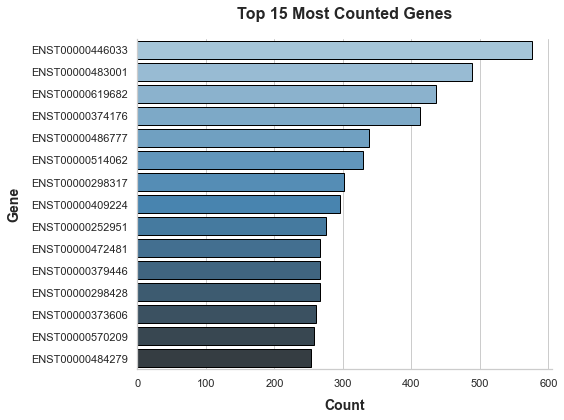

In [77]:
# Load data
output_path = Path(path1/"ranked_genes_1000.csv")
ranked_genes = pd.read_csv(output_path)

# Step 5: Plotting the Top 15 Most Counted Genes
top_genes_df = ranked_genes.nlargest(15, 'Count')  # Get the top 15 genes
top_genes_df = top_genes_df.sort_values('Count', ascending=False)  # Ensure they are sorted in descending order

# Set Seaborn style for professional plots
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Barplot - Horizontal
sns.barplot(
    x='Count',
    y='Gene',
    data=top_genes_df,
    palette='Blues_d',  # Use a scientific, muted color palette
    edgecolor='black'   # Add black edge for clarity
)

# Add labels and title
plt.xlabel('Count', fontsize=14, labelpad=10, fontweight='bold', fontname='Arial')
plt.ylabel('Gene', fontsize=14, labelpad=10, fontweight='bold', fontname='Arial')
plt.title('Top 15 Most Counted Genes', fontsize=16, fontweight='bold', fontname='Arial', pad=20)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits well
plt.show()


In [68]:
ranked_genes

,Gene,Count
0,ENST00000446033,53
1,ENST00000483001,44
2,ENST00000374176,42
3,ENST00000619682,41
4,ENST00000486777,37
...,...,...
95,ENST00000566718,3
96,ENST00000554367,2
97,ENST00000521086,1
98,ENST00000377685,1


# to selcet the best

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'subsample': 0.8, 'scale_pos_weight': 5, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.01}
AUC: 0.8825
Accuracy: 0.8293
Sensitivity: 0.9200
Specificity: 0.6875


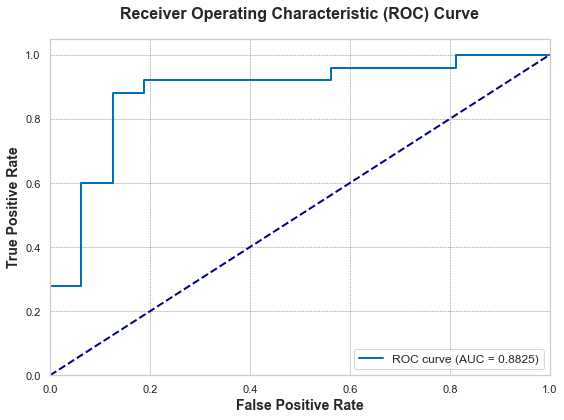

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix

# Step 1: Load the ranked genes and select the top 15
ranked_genes = pd.read_csv("ranked_genes.csv")
top_15_genes = ranked_genes['Gene'].head(15).tolist()

# Step 2: Subset the dataset to only include the top 15 genes
X_top15 = X1[top_15_genes]  
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'scale_pos_weight': [1, 2, 5]  # Useful for imbalanced classes
}

# Step 3: Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42)

# Step 4: Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of different combinations to try
    scoring='roc_auc',
    cv=3,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Step 5: Perform the search on your data
random_search.fit(X_top15, y)  # X_top15 is feature matrix and y is the label

# Step 6: Print the best hyperparameters
best_params = random_search.best_params_
print(f"Best hyperparameters: {best_params}")

# Step 7: Initialize the XGBoost model with best hyperparameters
xgb_model = XGBClassifier(**best_params)

# Step 8: Perform stratified k-fold cross-validation to compute metrics
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store predictions and true values for ROC
y_pred_proba = cross_val_predict(xgb_model, X_top15, y, cv=kf, method="predict_proba")[:, 1]
y_pred = cross_val_predict(xgb_model, X_top15, y, cv=kf, method="predict")

# Step 9: Compute metrics
auc_score = roc_auc_score(y, y_pred_proba)
accuracy = accuracy_score(y, y_pred)
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

# Print metrics
print(f"AUC: {auc_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# Step 10: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Set Seaborn style for professional plots
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(8, 6))

# Plot ROC curve
plt.plot(fpr, tpr, color='#0072B2', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line

# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold', fontname='Arial')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold', fontname='Arial')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold', fontname='Arial', pad=20)

# Add grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()  # Adjust the plot to ensure everything fits well
plt.show()


# Cross-Validation with XGBoost model
Cross-validation with 3 folds 

In [5]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 10,random_state=seed)

# Iterate through each fold
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)


    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
     # Calculate specificity, accuracy, and sensitivity
     # Calculate AU-ROC score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Append metrics to lists
    specificities.append(specificity)
    accuracies.append(accuracy)
    sensitivities.append(sensitivity)
    auc_scores.append(auc_score)

    # Print metrics for each fold
    print(f'Fold {i} - AUC: {auc_score}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')

# Print average and standard deviation of metrics
average_auc_score = np.mean(auc_score)
average_specificity = np.mean(specificities)
average_accuracy = np.mean(accuracies)
average_sensitivity = np.mean(sensitivities)
std_specificity = np.std(specificities)
std_accuracy = np.std(accuracies)
std_sensitivity = np.std(sensitivities)
std_auc_score = np.std(auc_scores)

print(f'\nAverage AUC: {average_auc_score:.4f} (±{std_auc_score:.4f})')
print(f'\nAverage Specificity: {average_specificity:.4f} (±{std_specificity:.4f})')
print(f'Average Accuracy: {average_accuracy:.4f} (±{std_accuracy:.4f})')
print(f'Average Sensitivity: {average_sensitivity:.4f} (±{std_sensitivity:.4f})')

Fold 1 - AUC: 1.0, Specificity: 0.8333, Accuracy: 0.9286, Sensitivity: 1.0000
Fold 2 - AUC: 0.8444444444444444, Specificity: 0.6000, Accuracy: 0.8571, Sensitivity: 1.0000
Fold 3 - AUC: 0.75, Specificity: 0.6000, Accuracy: 0.6154, Sensitivity: 0.6250
Fold 4 - AUC: 0.8125, Specificity: 0.6667, Accuracy: 0.7143, Sensitivity: 0.7500
Fold 5 - AUC: 0.9555555555555555, Specificity: 0.6000, Accuracy: 0.8571, Sensitivity: 1.0000
Fold 6 - AUC: 0.9750000000000001, Specificity: 0.8000, Accuracy: 0.9231, Sensitivity: 1.0000
Fold 7 - AUC: 1.0, Specificity: 0.5000, Accuracy: 0.7857, Sensitivity: 1.0000
Fold 8 - AUC: 1.0, Specificity: 0.4000, Accuracy: 0.7857, Sensitivity: 1.0000
Fold 9 - AUC: 0.7000000000000001, Specificity: 0.4000, Accuracy: 0.6154, Sensitivity: 0.7500
Fold 10 - AUC: 0.8541666666666667, Specificity: 0.5000, Accuracy: 0.7143, Sensitivity: 0.8750
Fold 11 - AUC: 0.9333333333333333, Specificity: 0.8000, Accuracy: 0.8571, Sensitivity: 0.8889
Fold 12 - AUC: 0.775, Specificity: 0.8000, Acc

# Skipping non valid results:
the result that are either of AUC, Specificity, Sensitivity is zero or one are excluded from the plot.

In [24]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20, random_state=seed)

# Iterate through each fold
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate specificity, accuracy, and sensitivity
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Check if any of the metrics is 0 or 1
    if 0 < auc_score < 1 and 0 < specificity < 1 and 0 < accuracy < 1 and 0 < sensitivity < 1:
        # Append metrics to lists only if they are valid
        auc_scores.append(auc_score)
        specificities.append(specificity)
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)

        # Print metrics for each valid fold
        print(f'Fold {i} - AUC: {auc_score:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')
    else:
        print(f"Fold {i} skipped due to invalid metrics (AUC: {auc_score}, Specificity: {specificity}, Accuracy: {accuracy}, Sensitivity: {sensitivity})")

# Check if we have valid metrics before calculating averages
if auc_scores:
    # Print average and standard deviation of metrics
    average_auc_score = np.mean(auc_scores)
    average_specificity = np.mean(specificities)
    average_accuracy = np.mean(accuracies)
    average_sensitivity = np.mean(sensitivities)

    std_auc_score = np.std(auc_scores)
    std_specificity = np.std(specificities)
    std_accuracy = np.std(accuracies)
    std_sensitivity = np.std(sensitivities)

    print(f'\nAverage AUC: {average_auc_score:.4f} (±{std_auc_score:.4f})')
    print(f'Average Specificity: {average_specificity:.4f} (±{std_specificity:.4f})')
    print(f'Average Accuracy: {average_accuracy:.4f} (±{std_accuracy:.4f})')
    print(f'Average Sensitivity: {average_sensitivity:.4f} (±{std_sensitivity:.4f})')
else:
    print("No valid folds found.")

Fold 1 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.8333333333333334, Accuracy: 0.9285714285714286, Sensitivity: 1.0)
Fold 2 skipped due to invalid metrics (AUC: 0.8444444444444444, Specificity: 0.6, Accuracy: 0.8571428571428571, Sensitivity: 1.0)
Fold 3 - AUC: 0.7500, Specificity: 0.6000, Accuracy: 0.6154, Sensitivity: 0.6250
Fold 4 - AUC: 0.8125, Specificity: 0.6667, Accuracy: 0.7143, Sensitivity: 0.7500
Fold 5 skipped due to invalid metrics (AUC: 0.9555555555555555, Specificity: 0.6, Accuracy: 0.8571428571428571, Sensitivity: 1.0)
Fold 6 skipped due to invalid metrics (AUC: 0.9750000000000001, Specificity: 0.8, Accuracy: 0.9230769230769231, Sensitivity: 1.0)
Fold 7 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.5, Accuracy: 0.7857142857142857, Sensitivity: 1.0)
Fold 8 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.4, Accuracy: 0.7857142857142857, Sensitivity: 1.0)
Fold 9 - AUC: 0.7000, Specificity: 0.4000, Accuracy: 0.6154, Sensitivity: 0.7500
Fold 10

# Ploting the valid results

Fold 1 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.8333333333333334, Accuracy: 0.9285714285714286, Sensitivity: 1.0)
Fold 2 skipped due to invalid metrics (AUC: 0.8444444444444444, Specificity: 0.6, Accuracy: 0.8571428571428571, Sensitivity: 1.0)
Fold 3 - AUC: 0.7500, Specificity: 0.6000, Accuracy: 0.6154, Sensitivity: 0.6250
Fold 4 - AUC: 0.8125, Specificity: 0.6667, Accuracy: 0.7143, Sensitivity: 0.7500
Fold 5 skipped due to invalid metrics (AUC: 0.9555555555555555, Specificity: 0.6, Accuracy: 0.8571428571428571, Sensitivity: 1.0)
Fold 6 skipped due to invalid metrics (AUC: 0.9750000000000001, Specificity: 0.8, Accuracy: 0.9230769230769231, Sensitivity: 1.0)
Fold 7 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.5, Accuracy: 0.7857142857142857, Sensitivity: 1.0)
Fold 8 skipped due to invalid metrics (AUC: 1.0, Specificity: 0.4, Accuracy: 0.7857142857142857, Sensitivity: 1.0)
Fold 9 - AUC: 0.7000, Specificity: 0.4000, Accuracy: 0.6154, Sensitivity: 0.7500
Fold 10

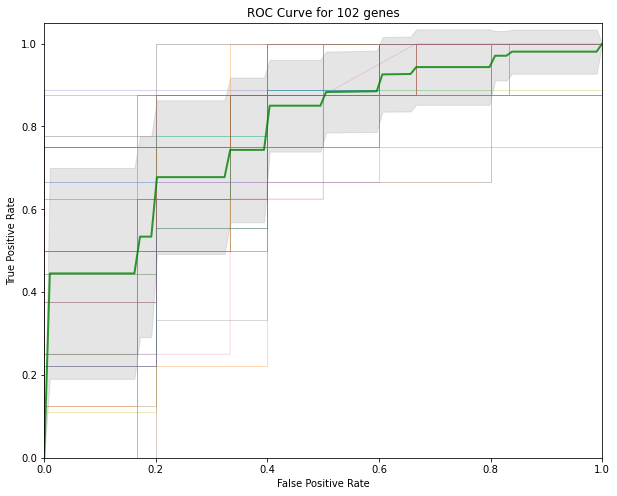

In [23]:

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
hyperparameters = {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
seed = 42

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(**hyperparameters, seed=seed)

# Initialize lists to store evaluation metrics
specificities = []
accuracies = []
sensitivities = []
auc_scores = []

# Initialize lists to store true labels and predicted probabilities for ROC curve
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# Stratified K-Fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20, random_state=seed)

# Plot setup
plt.figure(figsize=(10, 8))

# Iterate through each fold
valid_folds = 0  # To count valid folds
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_pred = xgb_model.predict(X_test)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate specificity, accuracy, sensitivity, and AUC
    auc_score = roc_auc_score(y_test, y_pred_proba)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)

    # Skip fold if any metric is invalid (i.e., 0 or 1)
    if 0 < auc_score < 1 and 0 < specificity < 1 and 0 < accuracy < 1 and 0 < sensitivity < 1:
        valid_folds += 1  # Increment valid fold count

        # Store valid fold metrics
        auc_scores.append(auc_score)
        specificities.append(specificity)
        accuracies.append(accuracy)
        sensitivities.append(sensitivity)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate the ROC curve
        tprs[-1][0] = 0.0

        # Plot the ROC curve for the current fold
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i} (AUC = {auc_score:.4f})')

        print(f'Fold {i} - AUC: {auc_score:.4f}, Specificity: {specificity:.4f}, Accuracy: {accuracy:.4f}, Sensitivity: {sensitivity:.4f}')
    else:
        print(f"Fold {i} skipped due to invalid metrics (AUC: {auc_score}, Specificity: {specificity}, Accuracy: {accuracy}, Sensitivity: {sensitivity})")

# Plot average ROC curve only if there are valid folds
if valid_folds > 0:
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    plt.plot(mean_fpr, mean_tpr, color='g', label=f'Mean ROC (AUC = {mean_auc:.4f})', lw=2, alpha=0.8)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label=r'± 1 std. dev.')

    # ROC curve formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 102 genes')
    #plt.legend(loc="lower right")
    plt.show()
else:
    print("No valid folds to plot.")


# Ploting the result of XGboost with 3 fold-cross validation

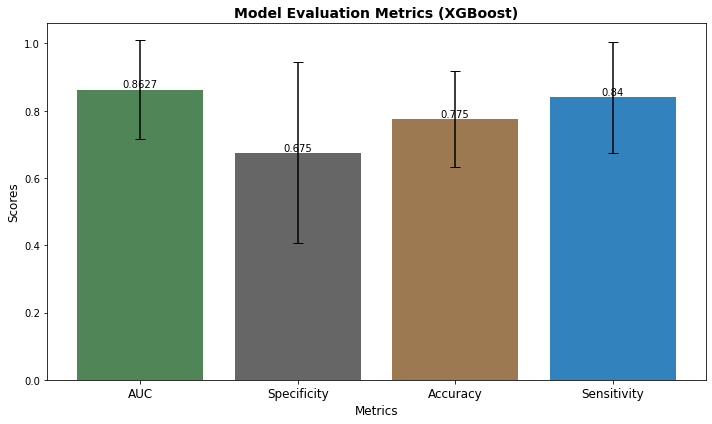

In [16]:
# Calculate mean and standard deviation for each metric
metrics = {
    'AUC': auc_scores,
    'Specificity': specificities,
    'Accuracy': accuracies,
    'Sensitivity': sensitivities
}

means = {metric: np.mean(values) for metric, values in metrics.items()}
stds = {metric: np.std(values) for metric, values in metrics.items()}

# Create a bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))

metric_names = list(means.keys())
x = np.arange(len(metric_names))

# Define a muted, professional color palette
colors = ['#508557', '#666666', '#9c7951', '#3182bd']

# Bar plot
bars = ax.bar(x, list(means.values()), yerr=list(stds.values()), capsize=5, color=colors)

# Add title and labels
ax.set_title('Model Evaluation Metrics (XGBoost)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=12)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), ha='center', va='bottom', fontsize=10)

# Improve layout and show plot
plt.tight_layout()
plt.show()


# Comparing the result for XGboost, Catboost, Random Forest, and SVM 
Cross-validated with 5 folds this time. Check which models overfitted!

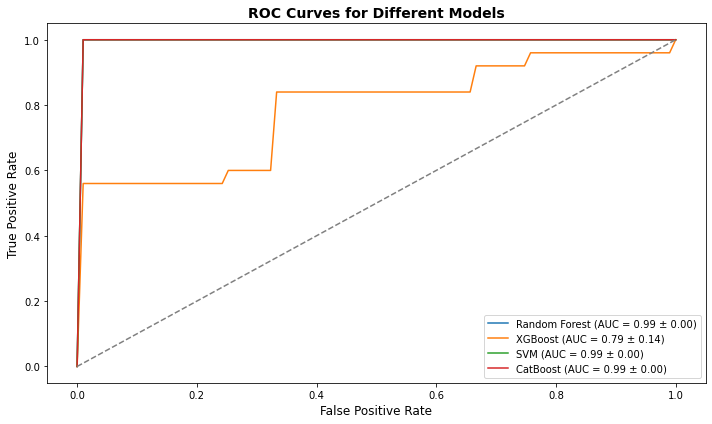

Random Forest - Average AUC: 1.0000 (±0.0000)
XGBoost - Average AUC: 0.7867 (±0.1424)
SVM - Average AUC: 1.0000 (±0.0000)
CatBoost - Average AUC: 1.0000 (±0.0000)


In [17]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define hyperparameters and seed
seed = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=seed),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', seed=seed),
    'SVM': SVC(probability=True, random_state=seed),
    'CatBoost': CatBoostClassifier(verbose=0, random_seed=seed)
}

# Initialize lists to store results
results = {model_name: [] for model_name in models.keys()}
mean_fpr = np.linspace(0, 1, 100)

# Initialize dictionary to store ROC curves
roc_curves = {model_name: [] for model_name in models.keys()}

# Cross-validation
for train_index, test_index in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        results[model_name].append(roc_auc)
        
        # Interpolate the ROC curve
        roc_curves[model_name].append(np.interp(mean_fpr, fpr, tpr))
        roc_curves[model_name][-1][0] = 0.0

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, scores in results.items():
    mean_tpr = np.mean(roc_curves[model_name], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(scores)
    ax.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')

# Add diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey')

# Add title and labels
ax.set_title('ROC Curves for Different Models', fontsize=14, fontweight='bold')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.show()

# Print average and standard deviation of AUC scores
for model_name, scores in results.items():
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    print(f'{model_name} - Average AUC: {mean_auc:.4f} (±{std_auc:.4f})')


# Comparing the same models as previously but exploring a bit the land of diverse hyperparameters 
See not much diference result compared with not exploring hyperparameter! useless effort.

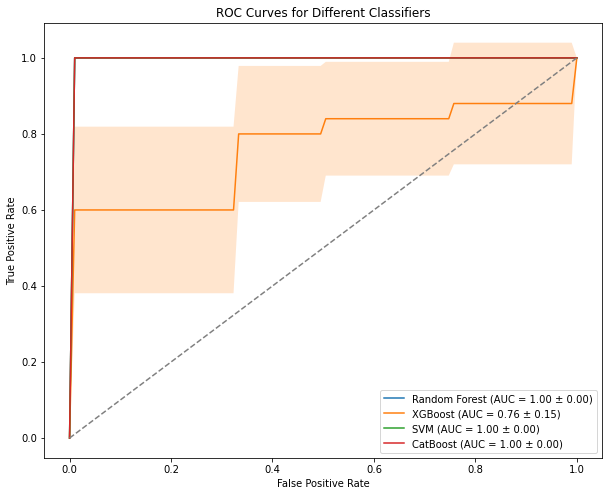

In [18]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Define classifiers with basic hyperparameters
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, random_state=42)
}

# Hyperparameter grids for tuning
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'CatBoost': {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'iterations': [100, 200]
    }
}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results dictionary
results = {name: {'auc': [], 'fpr': [], 'tpr': []} for name in classifiers.keys()}

# Perform cross-validation and hyperparameter tuning
for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grids[name], cv=cv, scoring='roc_auc')
    grid_search.fit(X_scaled, y)
    best_clf = grid_search.best_estimator_
    
    for train_index, test_index in cv.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        best_clf.fit(X_train, y_train)
        y_pred_proba = best_clf.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        results[name]['auc'].append(auc_score)
        results[name]['fpr'].append(fpr)
        results[name]['tpr'].append(tpr)

# Plotting ROC Curves
plt.figure(figsize=(10, 8))

for name in classifiers.keys():
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    
    for i in range(len(results[name]['auc'])):
        tprs.append(np.interp(mean_fpr, results[name]['fpr'][i], results[name]['tpr'][i]))
        tprs[-1][0] = 0.0
        aucs.append(auc(results[name]['fpr'][i], results[name]['tpr'][i]))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.plot(mean_fpr, mean_tpr, label=f'{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), alpha=0.2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend()
plt.show()


# Selecting top genes based on feature selction analysis:
See also the top 5 common genes 

In [106]:
current_date = datetime.now().date()
print("Last update :", current_date)

Last update : 2024-07-03
